### Notebook for the fibroblasts-mesenchymal cells reclustering

- **Developed by:** Anna Maguza
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- **Date:** 21st of January 2024

#### Import required modules

In [1]:
import scvi
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

/home/amaguza/miniforge3/envs/sccaf2_env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/amaguza/miniforge3/envs/sccaf2_env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/amaguza/miniforge3/envs/sccaf2_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

In [3]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Global seed set to 1712


In [4]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

#### Data Upload

In [5]:
adata= sc.read_h5ad('data_skin/SCC0120_1_Skin_scANVI_leiden_Anna.h5ad') 
adata

AnnData object with n_obs × n_vars = 7479 × 27449
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering', 'donor', 'cell_states', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'skin_condition', 'cell_type', 'leiden'
    var: 'gene_ids-SCC0120_1_skin', 'feature_types-SCC0120_1_skin', 'mt-SCC0120_1_skin', 'ribo-SCC0120_1_skin', 'n_cells_by_counts-SCC0120_1_skin', 'mean_counts-SCC0120_1_skin', 'pct_dropout_by_counts-SCC0

#### Filter fibroblasts-mesenchymal cells

In [6]:
adata = adata[adata.obs['leiden'].isin(['1', '2', '7', '8', '18', '19'])]

#### Perform scVI batch correction

+ Save raw counts

In [7]:
adata_raw = adata.copy()

+ Calculate HVGs

In [8]:
adata.layers['counts'] = adata.X.copy()

In [9]:
sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "donor",
    subset = True
)

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 2371 × 7000
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering', 'donor', 'cell_states', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'skin_condition', 'cell_type', 'leiden'
    var: 'gene_ids-SCC0120_1_skin', 'feature_types-SCC0120_1_skin', 'mt-SCC0120_1_skin', 'ribo-SCC0120_1_skin', 'n_cells_by_counts-SCC0120_1_skin', 'mean_counts-SCC0120_1_skin', 'pct_dropout_by_counts-SCC01

+ Batch correction and data integration with scVI

In [10]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer = "counts",
    batch_key = "donor",
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [11]:
model = scvi.model.SCVI(adata, n_layers = 3, n_latent = 50, gene_likelihood = "nb", dispersion = 'gene-batch')
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 50, n_layers: 3, dropout_rate: 0.1, dispersion: gene-batch, gene_likelihood: nb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

+ Train the model

In [12]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 400/400: 100%|████████| 400/400 [00:41<00:00,  8.83it/s, v_num=1, train_loss_step=4.43e+3, train_loss_epoch=4.42e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████| 400/400 [00:41<00:00,  9.68it/s, v_num=1, train_loss_step=4.43e+3, train_loss_epoch=4.42e+3]


+ Save latent representation

In [13]:
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

+ Calculate UMAP

In [14]:
sc.pp.neighbors(adata, use_rep = "X_scVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 1, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


In [ ]:
sc.set_figure_params(dpi=300)
sc.pl.umap(adata, frameon = False, color = ["donor", 'C_scANVI', "skin_condition", 'leiden'], size = 12, legend_fontsize = 5, ncols = 4, color_map='magma')

+ Copy old leiden clustering to separate column 'leiden_2'

In [16]:
adata.obs['leiden_2'] = adata.obs['leiden'].copy()

#### Leiden clustering and assessment with SCCAF

In [17]:
import SCCAF
from SCCAF import SCCAF_assessment, plot_roc

+ Return to raw counts

In [18]:
adata

AnnData object with n_obs × n_vars = 2371 × 7000
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering', 'donor', 'cell_states', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'skin_condition', 'cell_type', 'leiden', 'leiden_2'
    var: 'gene_ids-SCC0120_1_skin', 'feature_types-SCC0120_1_skin', 'mt-SCC0120_1_skin', 'ribo-SCC0120_1_skin', 'n_cells_by_counts-SCC0120_1_skin', 'mean_counts-SCC0120_1_skin', 'pct_dropout_by_

In [19]:
adata = anndata.AnnData(X = adata_raw.X.copy(), obs = adata.obs.copy(), 
                        var = adata_raw.var.copy(), uns = adata.uns.copy(),
                        obsm = adata.obsm.copy(),
                        obsp = adata.obsp.copy())

In [20]:
adata

AnnData object with n_obs × n_vars = 2371 × 27449
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering', 'donor', 'cell_states', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'skin_condition', 'cell_type', 'leiden', 'leiden_2'
    var: 'gene_ids-SCC0120_1_skin', 'feature_types-SCC0120_1_skin', 'mt-SCC0120_1_skin', 'ribo-SCC0120_1_skin', 'n_cells_by_counts-SCC0120_1_skin', 'mean_counts-SCC0120_1_skin', 'pct_dropout_by

+ Save raw counts

In [21]:
adata.raw = adata

+ Normalize and log transform

In [22]:
adata_log = adata.copy()
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)


+ Resolution 0.5

In [23]:
sc.tl.leiden(adata_log, resolution = 0.5, random_state = 1712)

running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Mean CV accuracy: 0.8919
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.8937


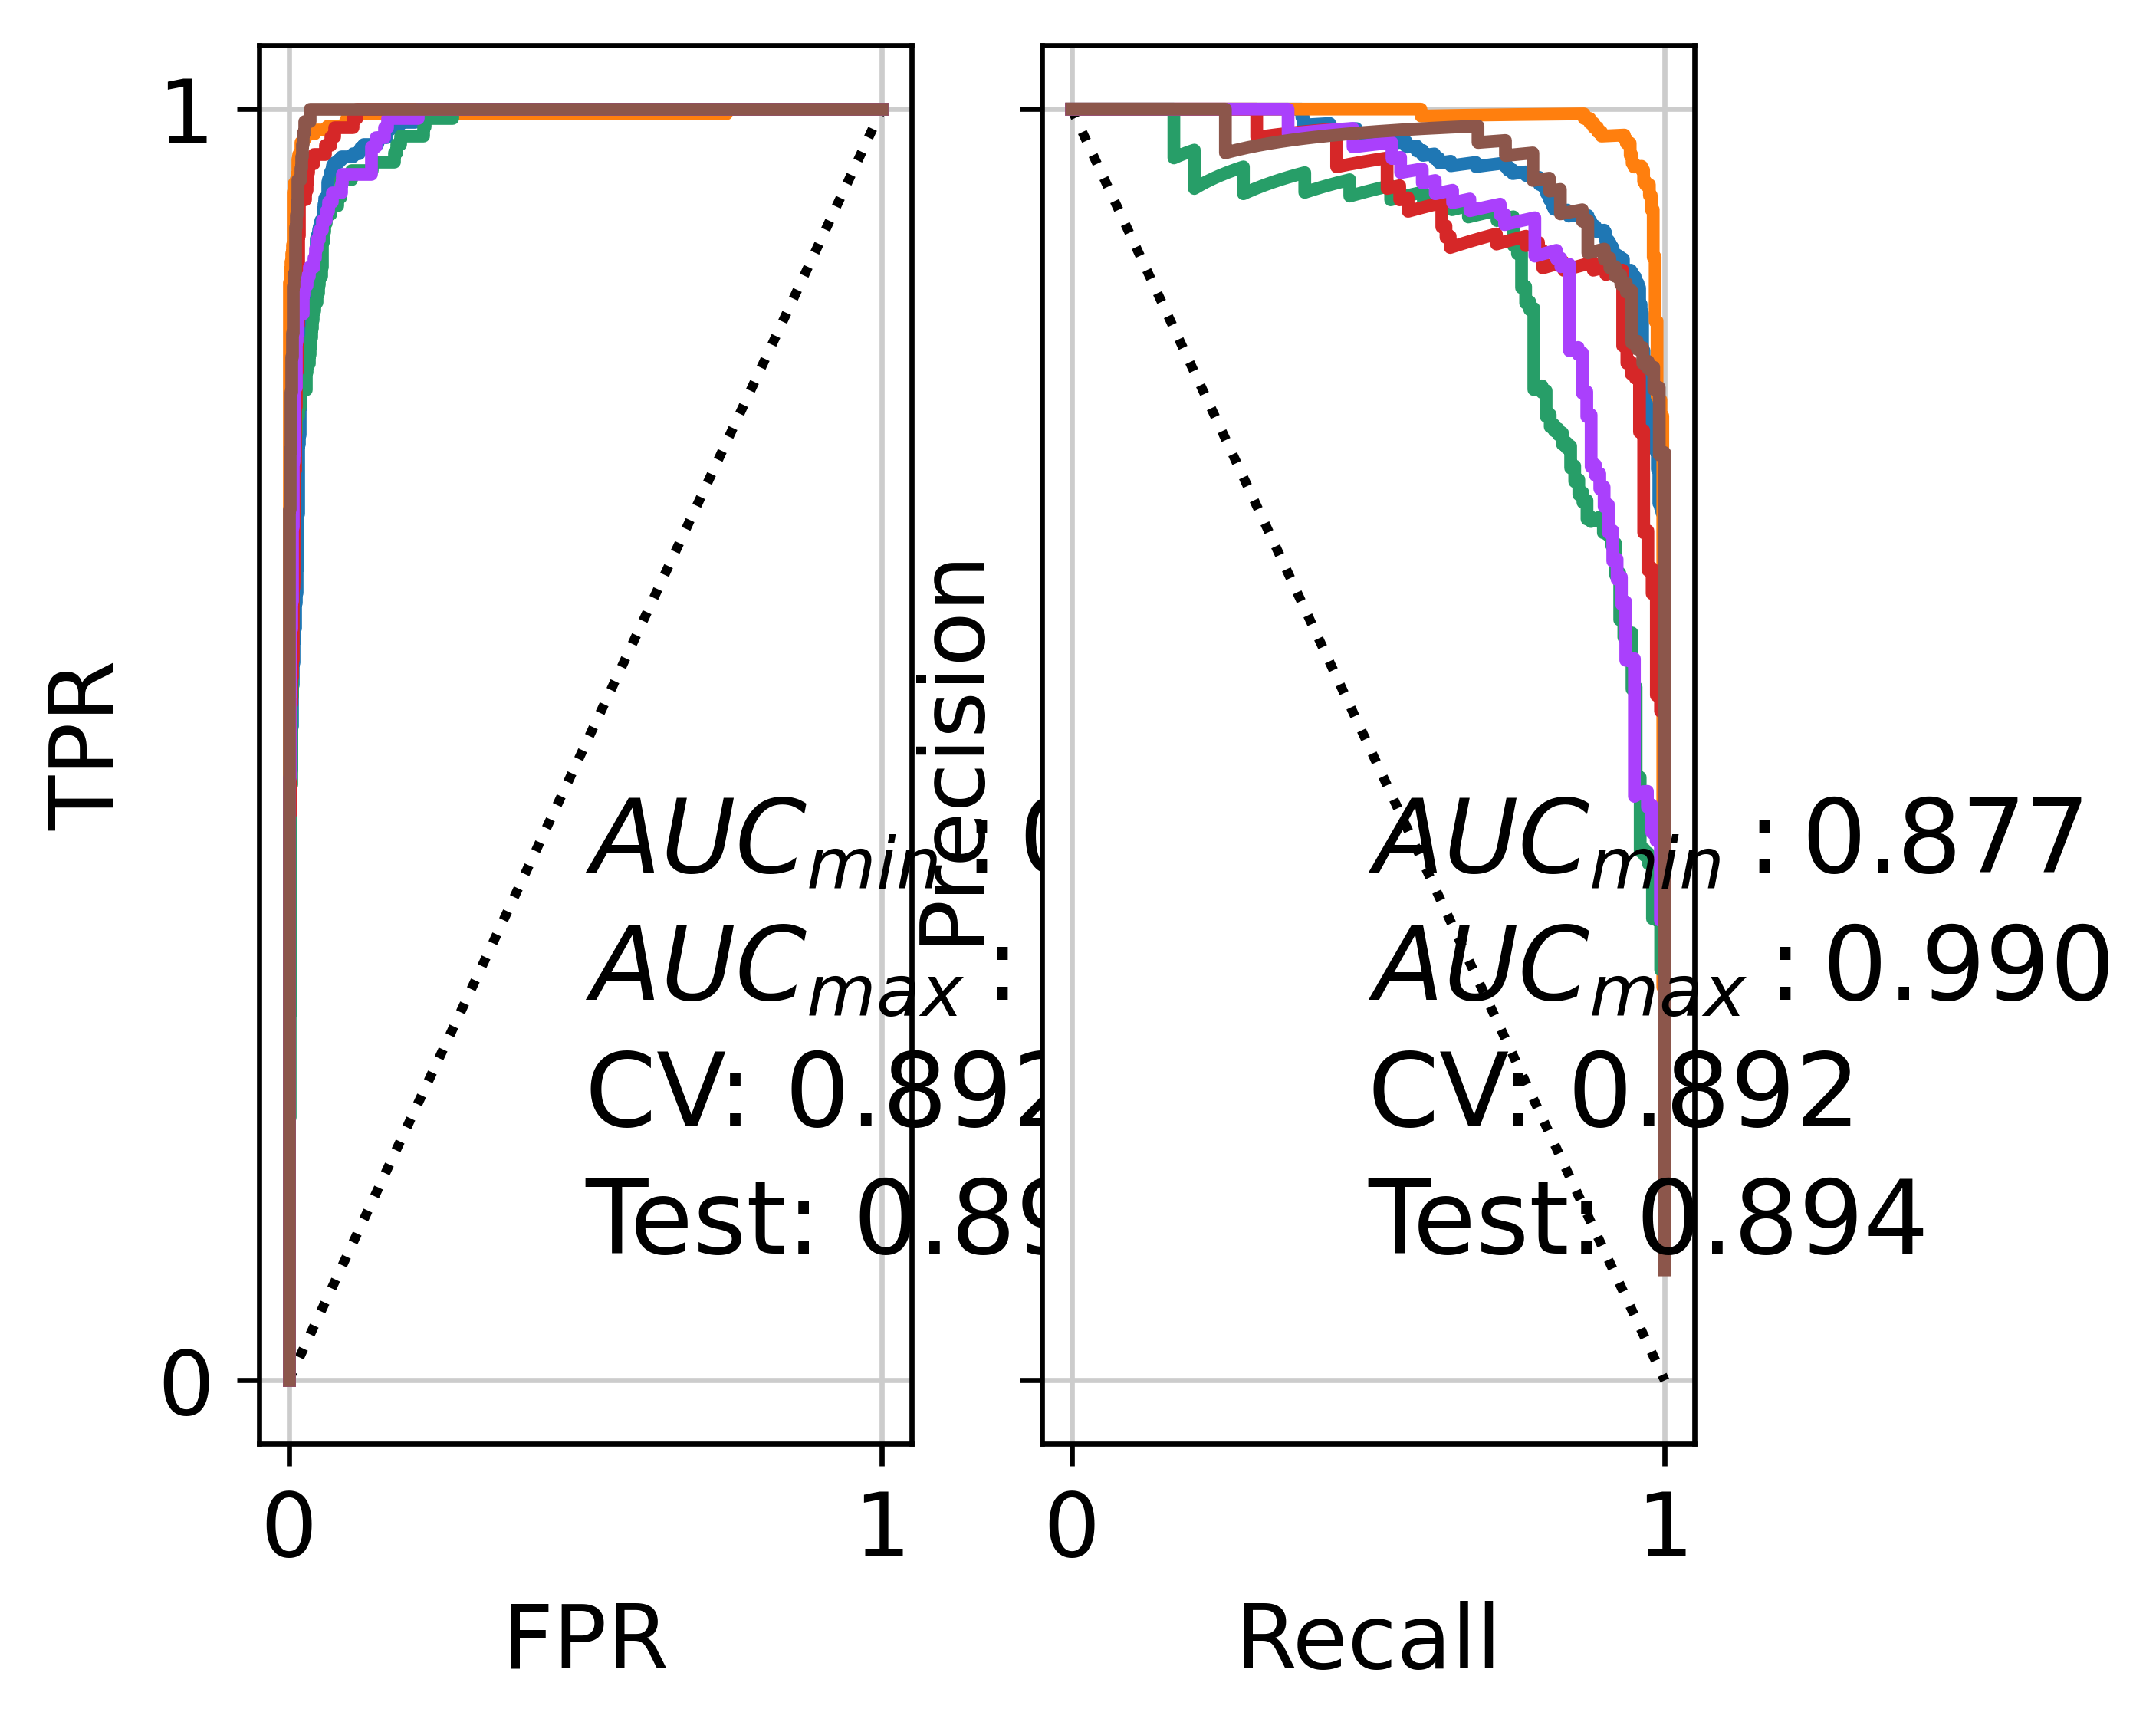

In [24]:
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata_log.X, adata_log.obs['leiden'], n = 300)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)
plt.rcParams["figure.figsize"] = (16,6)
plt.show()

+ Visualize clustering on the UMAP

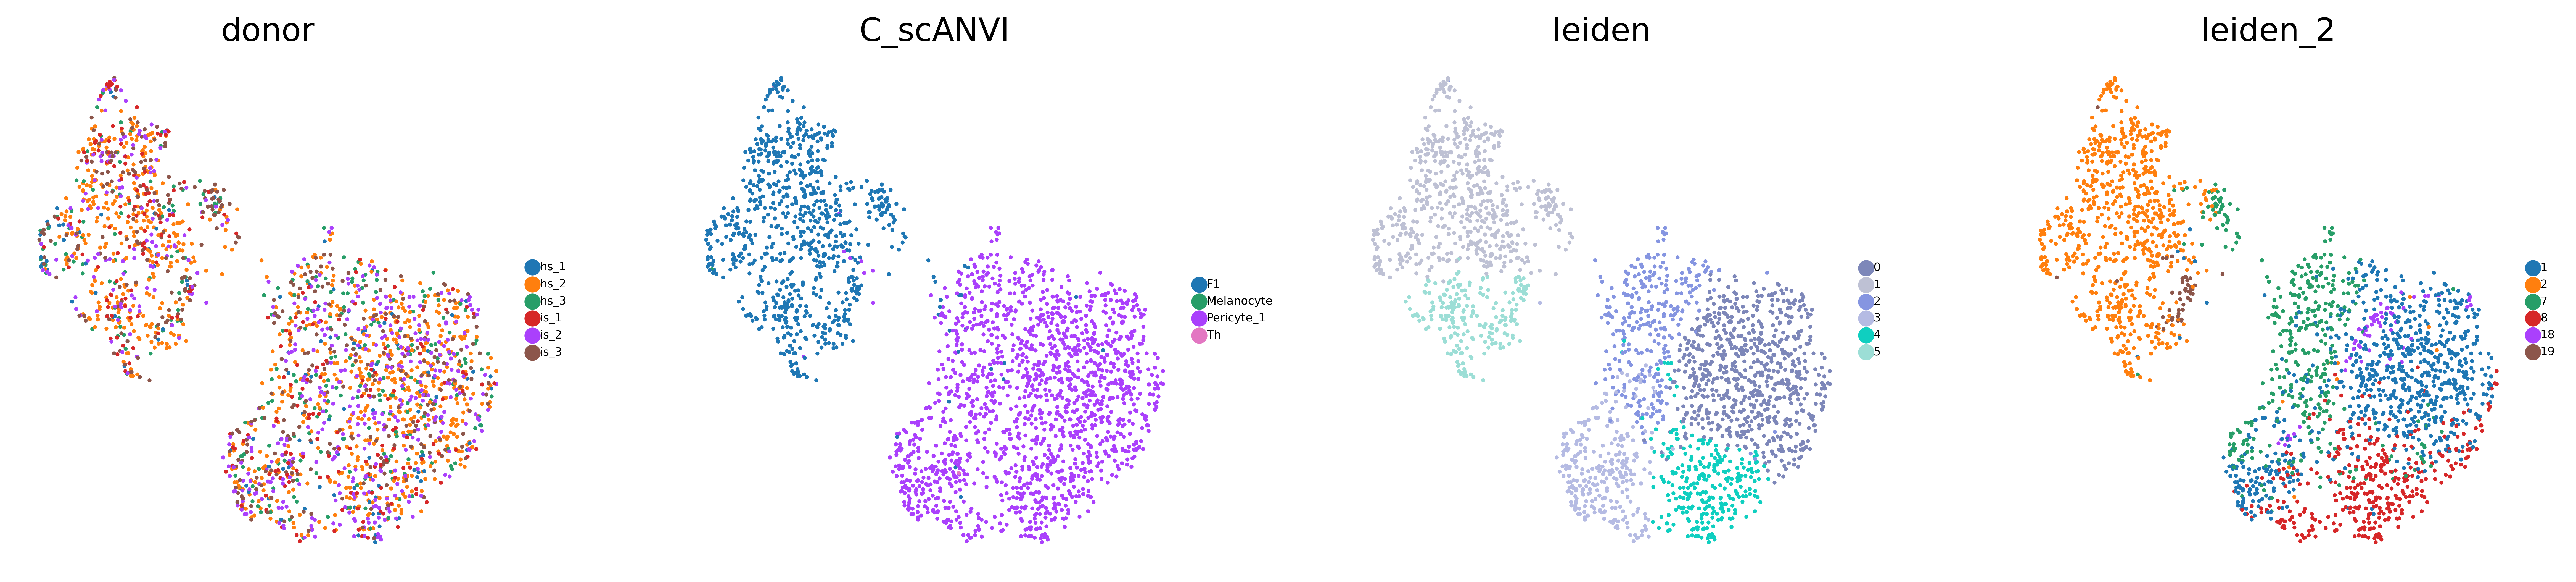

In [25]:
sc.set_figure_params(dpi=300)
sc.pl.umap(adata_log, frameon = False, color = ["donor", 'C_scANVI', "leiden", 'leiden_2'], size = 12, legend_fontsize = 5, ncols = 4, color_map='magma')

#### Annotate clusters

* Identify differentially expressed genes

In [26]:
sc.tl.rank_genes_groups(adata_log, groupby="leiden", method="wilcoxon", n_genes = 100)
df = sc.get.rank_genes_groups_df(adata_log, group=None)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


* Save DEGs

In [ ]:
df.to_csv('data_skin/Fibroblasts_mesenchymal_reclustered_DEG_2.csv')

+ Visualise top 25 genes

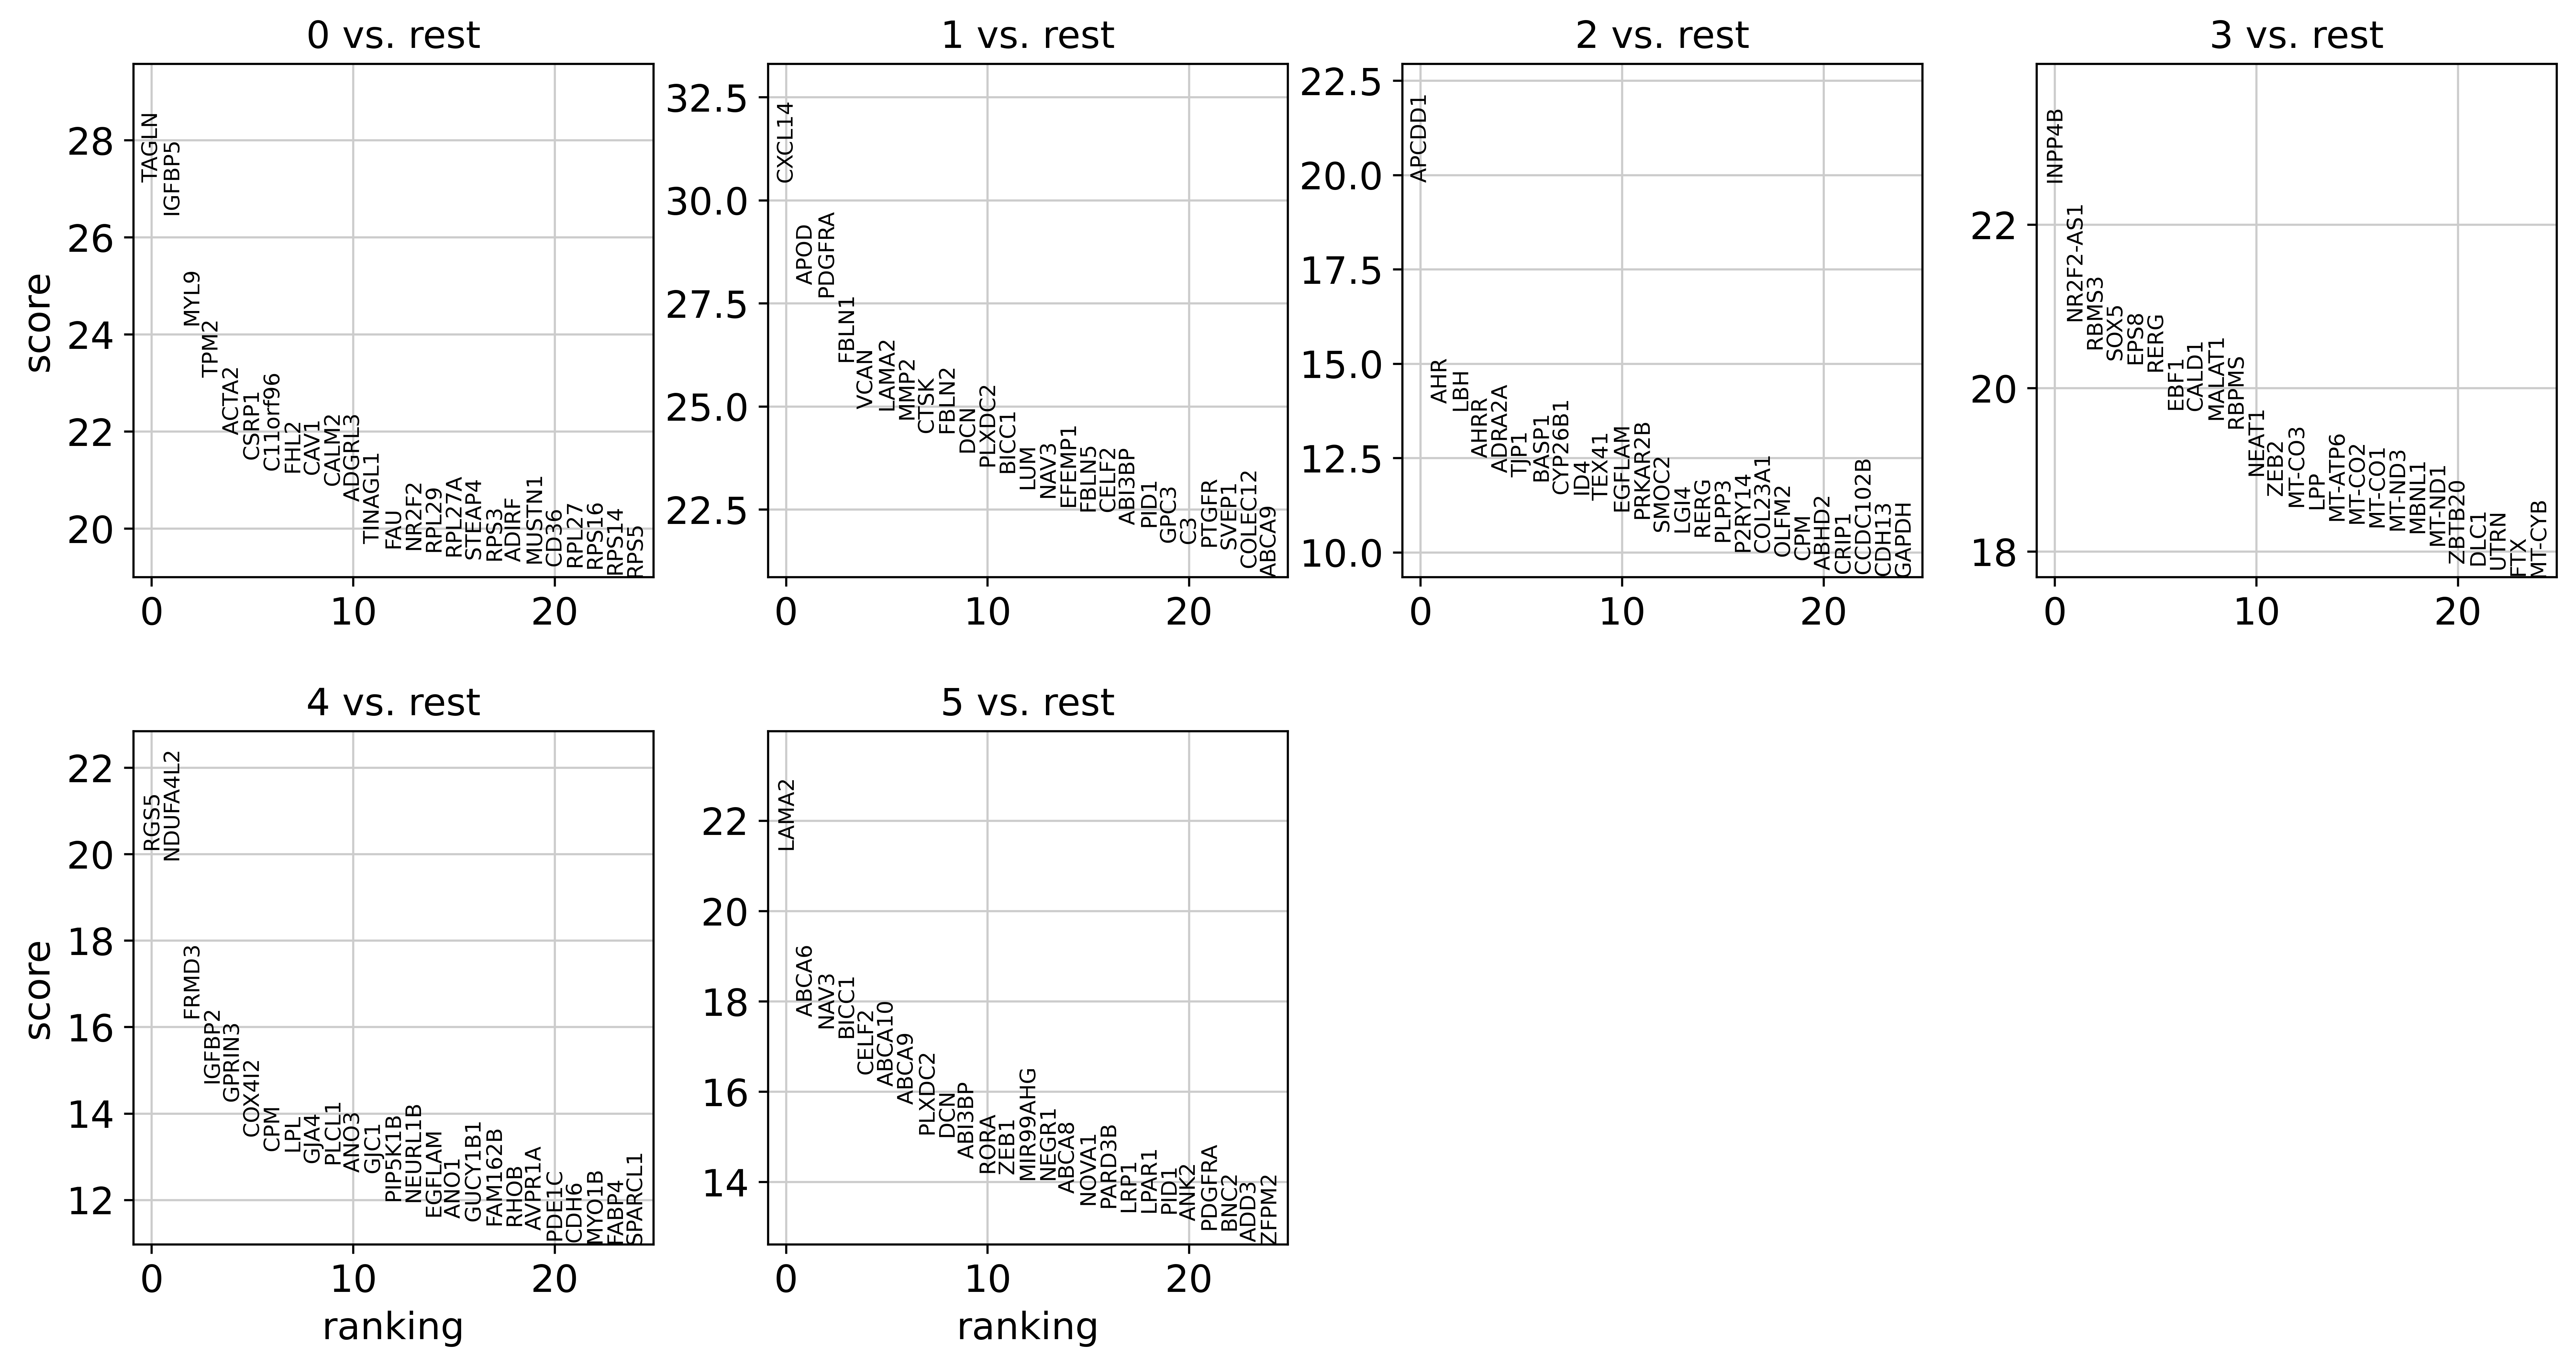

In [27]:
sc.pl.rank_genes_groups(adata_log, n_genes=25, sharey=False)

* Fibroblasts

In [ ]:
fibroblasts_genes = ['MMP2', 'COL1A1', 'COL1A2', 'NT5E', 'COL6A1']

sc.tl.score_genes(adata_log, fibroblasts_genes, score_name = 'fibroblasts_score')

In [ ]:
sc.set_figure_params(dpi=300)
sc.pl.umap(adata_log, frameon = False, color = ['MMP2', 'COL1A1', 'COL1A2', 'NT5E', 'COL6A1', 'fibroblasts_score', 'leiden'], size = 10, legend_fontsize = 5, ncols = 3, color_map='magma_r')

In [ ]:
sc.set_figure_params(dpi=300)
sc.pl.umap(adata_log, frameon = False, color = ['ELN', 'MMP2', 'QPCT', 'SFRP2', 'leiden'], size = 10, legend_fontsize = 5, ncols = 3, color_map='magma_r')

In [ ]:
sc.set_figure_params(dpi=300)
sc.pl.umap(adata_log, frameon = False, color = ['APOE', 'C7', 'CYGB', 'IGFBP7', 'leiden'], size = 10, legend_fontsize = 5, ncols = 3, color_map='magma_r')

In [ ]:
sc.set_figure_params(dpi=300)
sc.pl.umap(adata_log, frameon = False, color = ['DKK3', 'TNMD', 'TNN', 'WFDC1', 'leiden'], size = 10, legend_fontsize = 5, ncols = 3, color_map='magma_r')

+ Advential Fibroblasts

In [ ]:
adv_fibroblasts_genes = ['VIM', 'COL1A1', 'ITGB1', 'CD44', 'ENG']
sc.tl.score_genes(adata_log, adv_fibroblasts_genes, score_name = 'adv_fibroblasts_score1')

sc.set_figure_params(dpi=300)
sc.pl.umap(adata_log, frameon = False, color = ['VIM', 'COL1A1', 'ITGB1', 'CD44', 'ENG', 'adv_fibroblasts_score1'], size = 14, legend_fontsize = 5, ncols = 3, color_map='magma_r')

+ Advential Fibroblasts

In [ ]:
adv_fibroblasts_genes2 = ['COL1A1', 'ENO2', 'AIFM2', 'S100A4', 'GLI1', 'PTCH1', 'PTCH2', 'PDGFRA', 'ATXN1', 'TCF21']
sc.tl.score_genes(adata_log, adv_fibroblasts_genes2, score_name = 'adv_fibroblasts_score2')

sc.set_figure_params(dpi=300)
sc.pl.umap(adata_log, frameon = False, color = ['COL1A1', 'ENO2', 'AIFM2', 'S100A4', 'GLI1', 'PTCH1', 'PTCH2', 'PDGFRA', 'ATXN1', 'TCF21', 'adv_fibroblasts_score2', 'leiden'], size = 12, legend_fontsize = 5, ncols = 4, color_map='magma_r')

In [ ]:
sc.set_figure_params(dpi=300)
sc.pl.umap(adata_log, frameon = False, color = ['PI16', 'DCN', 'leiden'], size = 12, legend_fontsize = 5, ncols = 4, color_map='magma_r')

In [ ]:
sc.set_figure_params(dpi=300)
sc.pl.umap(adata_log, frameon = False, color = ['SERPINF1', 'SFRP2', 'PI16'], size = 12, legend_fontsize = 5, ncols = 4, color_map='magma_r')

In [ ]:
sc.set_figure_params(dpi=300)
sc.pl.umap(adata_log, frameon = False, color = ['ASPN', 'WIF1', 'FGF18', 'SCX', 'LGR6'], size = 12, legend_fontsize = 5, ncols = 4, color_map='magma_r')

+ Vascular Stem Cells

In [ ]:
vSC = ['ANPEP', 'NT5E', 'THY1', 'ITGB1', 'CD44', 'ENG']
sc.tl.score_genes(adata_log, vSC, score_name = 'vSC_score')

sc.set_figure_params(dpi=300)
sc.pl.umap(adata_log, frameon = False, color = ['ANPEP', 'NT5E', 'THY1', 'ITGB1', 'CD44', 'ENG', 'vSC_score'], size = 12, legend_fontsize = 5, ncols = 4, color_map='magma_r')

In [ ]:
pericytes_genes = ['KCNJ8', 'ABCC9', 'VTN', 'ANPEP', 'CD248']

sc.tl.score_genes(adata_log, pericytes_genes, score_name = 'pericytes_score')

sc.set_figure_params(dpi=300)
sc.pl.umap(adata_log, frameon = False, color = ['KCNJ8', 'ABCC9', 'VTN', 'ANPEP', 'CD248', 'pericytes_score', 'leiden'], size = 15, legend_fontsize = 5, ncols = 4, color_map='magma_r')

+ Vascular Smooth Muscle Genes

In [ ]:
VSMC_genes = ['ACTA2', 'TAGLN', 'MYH11', 'PDGFRB', 'CNN1', 'TAGLN2', 'MYL9', 'RGS5', 'MYLK', 'HHIP', 'GJA4', 'NOX4']
sc.tl.score_genes(adata_log, VSMC_genes, score_name = 'vsmc_score')
sc.set_figure_params(dpi=300)
sc.pl.umap(adata_log, frameon = False, color = ['ACTA2', 'TAGLN', 'MYH11', 'PDGFRB', 'CNN1', 'TAGLN2', 'MYL9', 'RGS5', 'MYLK', 'HHIP', 'GJA4', 'NOX4', 'vsmc_score'], size = 12, legend_fontsize = 5, ncols = 5, color_map='magma_r')

+ Vascular Stem cells

In [ ]:
vSC = ['ANPEP', 'NT5E', 'THY1', 'ITGB1', 'CD44', 'ENG']
sc.tl.score_genes(adata_log, vSC, score_name = 'vSC_score')

sc.set_figure_params(dpi=300)
sc.pl.umap(adata_log, frameon = False, color = ['ANPEP', 'NT5E', 'THY1', 'ITGB1', 'CD44', 'ENG', 'vSC_score'], size = 12, legend_fontsize = 5, ncols = 3, color_map='magma_r')

In [ ]:
# Save anndata
adata.write_h5ad('data_skin/Fibroblasts_mesenchymal_reclustered_2.h5ad')